In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, BertTokenizerFast, BertForSequenceClassification, RobertaTokenizerFast, RobertaForSequenceClassification, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Load your dataset
df = pd.read_csv('/content/drive/My Drive/annotatted_dataset.csv')

# Compute class distribution
class_counts = df['category'].value_counts()
print(class_counts)

category
Functionality and Features             3878
Performance and Stability              2289
User Interface and UX                  1140
Compatibility and Device Issues         865
Customer Support and Responsiveness     652
Security and Privacy Concerns           146
Name: count, dtype: int64


<ipython-input-3-dc6823c1d59c>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df, x='category_code', discrete=True, palette='Set2')


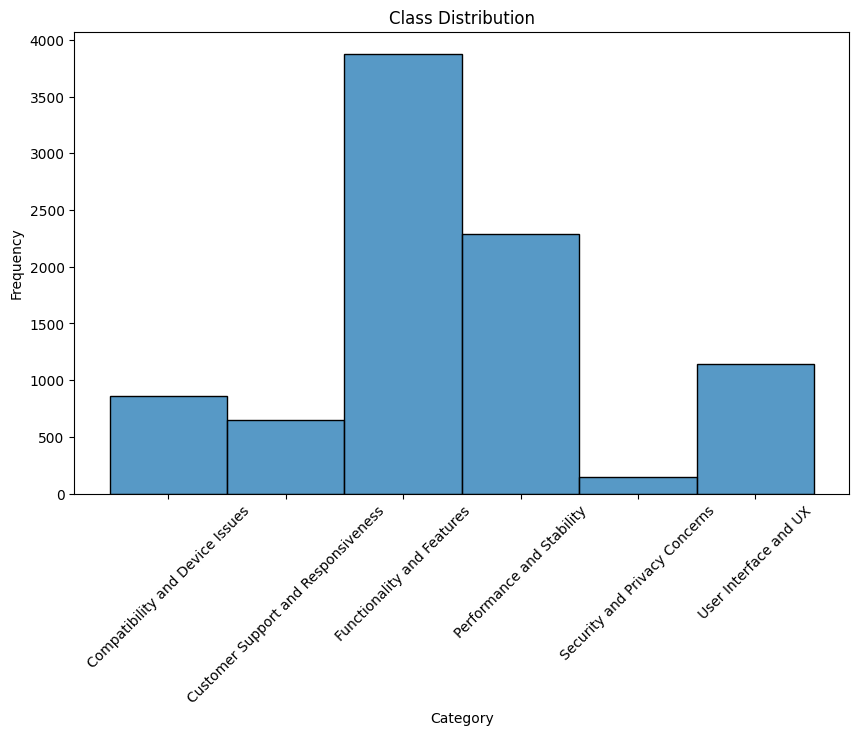

In [ ]:
# Convert categorical class labels to numeric codes
df['category_code'] = df['category'].astype('category').cat.codes

# Create a histogram of class distribution
plt.figure(figsize=(10, 6))
sns.histplot(df, x='category_code', discrete=True, palette='Set2')
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(df['category'].astype('category').cat.categories)),
           labels=df['category'].astype('category').cat.categories,
           rotation=45)
plt.show()


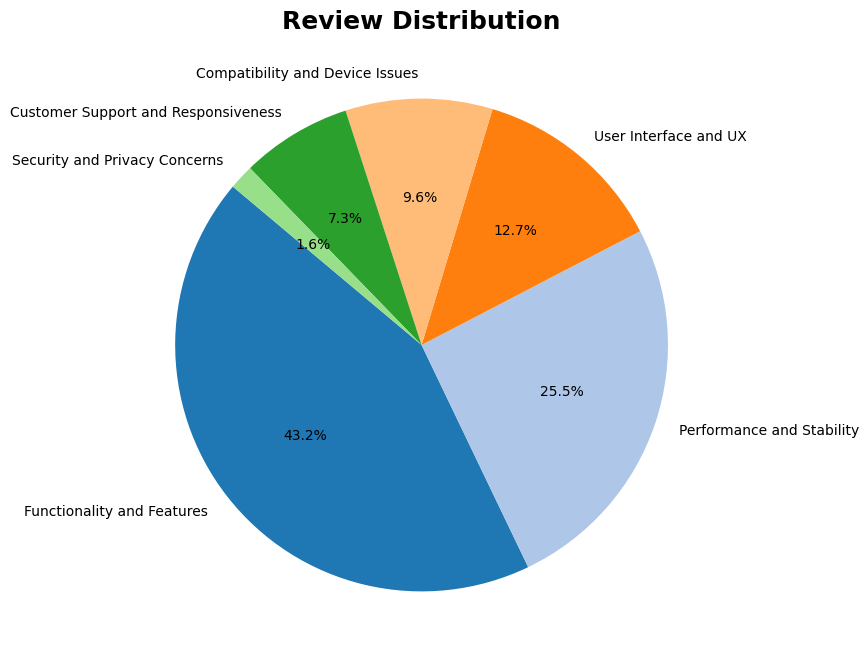

In [ ]:
# Plot the class distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.get_cmap('tab20').colors)
plt.title('Review Distribution', fontsize=18, fontweight='bold')
plt.show()


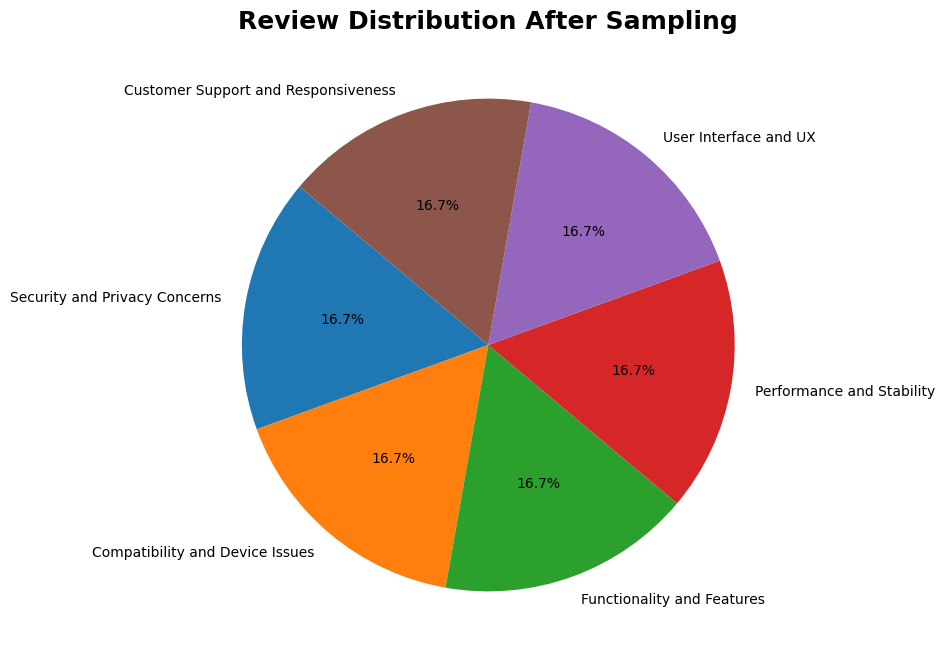

In [ ]:
# Balance the dataset
df_majority = df[df['category'] == df['category'].value_counts().idxmax()]
df_minority = [df[df['category'] == cls] for cls in df['category'].unique() if cls != df['category'].value_counts().idxmax()]

# Upsample minority classes
df_minority_upsampled = [resample(minority, replace=True, n_samples=len(df_majority), random_state=42) for minority in df_minority]

# Combine majority class with upsampled minority classes
df_balanced = pd.concat([df_majority] + df_minority_upsampled)

# Shuffle the dataset
df = df_balanced.sample(frac=1, random_state=42)

# Display the class distribution
class_counts = df['category'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Review Distribution After Sampling', fontsize=18, fontweight='bold')
plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (820 > 512). Running this sequence through the model will result in indexing errors


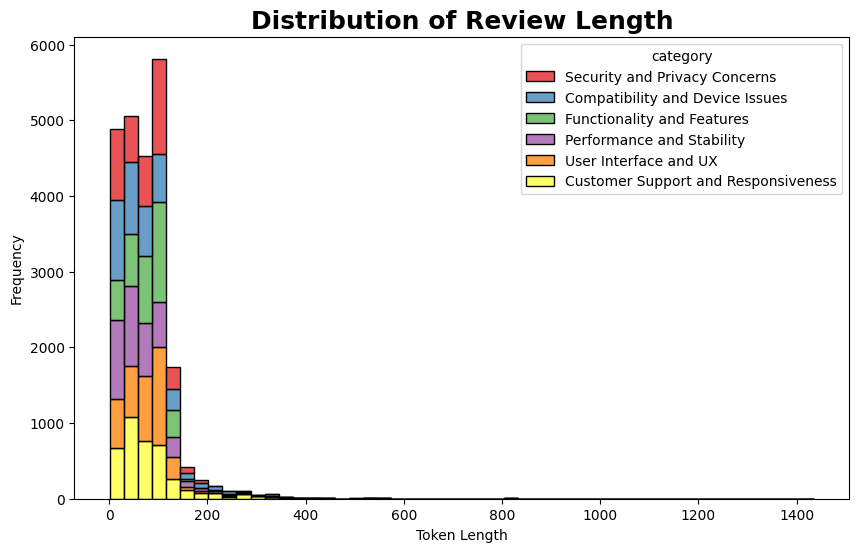

In [ ]:
# Convert categorical labels to numeric
df['category'] = df['category'].astype('category').cat.codes

if df['category'].dtype.name == 'category':
    df['category'] = df['category'].cat.codes

# Mapping from numeric to original labels
category_mapping = {
    0: 'Compatibility and Device Issues',
    1: 'Customer Support and Responsiveness',
    2: 'Functionality and Features',
    3: 'Performance and Stability',
    4: 'Security and Privacy Concerns',
    5: 'User Interface and UX'
}

# Apply the mapping
df['category'] = df['category'].map(category_mapping)

# Initialize DistilBERT tokenizer
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the text and compute token length
df['token_length'] = df['Base_Reviews'].apply(lambda x: len(distilbert_tokenizer.tokenize(x)))

# Plot the distribution of token lengths with actual class names
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='token_length', hue='category', multiple='stack', palette='Set1', bins=50)
plt.title('Distribution of Review Length', fontsize=18, fontweight='bold')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Convert categorical class labels to numeric codes
df['category_code'] = df['category'].astype('category').cat.codes
df['category'] = df['category_code']

# Initialize DistilBERT tokenizer
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize data for DistilBERT
def tokenize_data_distilbert(data):
    return distilbert_tokenizer(data['Base_Reviews'].tolist(), padding='max_length', truncation=True, max_length=128, return_tensors='pt', return_attention_mask=True)

# Apply the tokenization function
tokenized_data_distilbert = tokenize_data_distilbert(df)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class TextDatasetDistilBERT(Dataset):
    def __init__(self, inputs, labels, attention_masks):
        self.inputs = inputs
        self.labels = labels
        self.attention_masks = attention_masks

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx].clone().detach().to(torch.long),
            'attention_mask': self.attention_masks[idx].clone().detach().to(torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are long
        }



In [ ]:
from transformers import get_linear_schedule_with_warmup

model_distilbert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(df['category'].unique()))
optimizer_distilbert = AdamW(model_distilbert.parameters(), lr=2e-5)
scheduler = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_distilbert.to(device)
# Train model for DistilBert
def train_model_distilbert(train_loader, val_loader, epochs):
    # Initialize the learning rate scheduler
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer_distilbert, num_warmup_steps=0, num_training_steps=total_steps)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model_distilbert.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            optimizer_distilbert.zero_grad()
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_distilbert(inputs, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer_distilbert.step()
            scheduler.step()  # Update learning rate

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        avg_train_accuracy = correct_predictions / total_samples
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)

        # Validation
        model_distilbert.eval()
        val_loss = 0
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_ids'].to(device)
                attention_masks = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model_distilbert(inputs, attention_mask=attention_masks, labels=labels)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct_predictions += torch.sum(preds == labels).item()
                total_samples += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = correct_predictions / total_samples
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')

    return model_distilbert, history

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
kf = KFold(n_splits=5)
accuracies_distilbert = []
train_losses_distilbert = []
val_losses_distilbert = []
train_accuracies_distilbert = []
val_accuracies_distilbert = []

for train_idx, val_idx in kf.split(tokenized_data_distilbert['input_ids']):
    # Split tokenized data
    train_inputs_distilbert = tokenized_data_distilbert['input_ids'][train_idx]
    val_inputs_distilbert = tokenized_data_distilbert['input_ids'][val_idx]
    train_attention_masks_distilbert = tokenized_data_distilbert['attention_mask'][train_idx]
    val_attention_masks_distilbert = tokenized_data_distilbert['attention_mask'][val_idx]

    # Labels
    train_labels_distilbert = df['category'].iloc[train_idx].values
    val_labels_distilbert = df['category'].iloc[val_idx].values

    # Create datasets
    train_dataset_distilbert = TextDatasetDistilBERT(train_inputs_distilbert, train_labels_distilbert, train_attention_masks_distilbert)
    val_dataset_distilbert = TextDatasetDistilBERT(val_inputs_distilbert, val_labels_distilbert, val_attention_masks_distilbert)

    # Create dataloaders
    train_loader_distilbert = DataLoader(train_dataset_distilbert, batch_size=16, shuffle=True)
    val_loader_distilbert = DataLoader(val_dataset_distilbert, batch_size=16)

    # Train model
    model_distilbert, history_distilbert = train_model_distilbert(train_loader_distilbert, val_loader_distilbert, epochs=6)

    # Collect history
    train_losses_distilbert.extend(history_distilbert['train_loss'])
    val_losses_distilbert.extend(history_distilbert['val_loss'])
    train_accuracies_distilbert.extend(history_distilbert['train_accuracy'])
    val_accuracies_distilbert.extend(history_distilbert['val_accuracy'])



Epoch 1, Train Loss: 0.8359, Train Accuracy: 0.6965, Val Loss: 0.4990, Val Accuracy: 0.8212
Epoch 2, Train Loss: 0.3363, Train Accuracy: 0.8881, Val Loss: 0.2954, Val Accuracy: 0.9087
Epoch 3, Train Loss: 0.1736, Train Accuracy: 0.9475, Val Loss: 0.2600, Val Accuracy: 0.9151
Epoch 4, Train Loss: 0.1141, Train Accuracy: 0.9664, Val Loss: 0.2352, Val Accuracy: 0.9347
Epoch 5, Train Loss: 0.0804, Train Accuracy: 0.9762, Val Loss: 0.2217, Val Accuracy: 0.9401
Epoch 6, Train Loss: 0.0636, Train Accuracy: 0.9789, Val Loss: 0.2198, Val Accuracy: 0.9426
Epoch 1, Train Loss: 0.1570, Train Accuracy: 0.9515, Val Loss: 0.0894, Val Accuracy: 0.9734
Epoch 2, Train Loss: 0.0956, Train Accuracy: 0.9716, Val Loss: 0.0833, Val Accuracy: 0.9770
Epoch 3, Train Loss: 0.0788, Train Accuracy: 0.9754, Val Loss: 0.0793, Val Accuracy: 0.9768
Epoch 4, Train Loss: 0.0630, Train Accuracy: 0.9788, Val Loss: 0.0868, Val Accuracy: 0.9746
Epoch 5, Train Loss: 0.0554, Train Accuracy: 0.9799, Val Loss: 0.0813, Val Accur

In [ ]:
# Accuracy calculation
accuracy_distilbert = sum([pred == label for pred, label in zip(preds_distilbert, true_labels_distilbert)]) / len(true_labels_distilbert)
accuracies_distilbert.append(accuracy_distilbert)
model_distilbert.eval()
pred_probs_distilbert, true_labels_distilbert = [], []
with torch.no_grad():
    for batch in val_loader_distilbert:
        inputs = batch['input_ids'].to(device)
        attention_masks = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_distilbert(inputs, attention_mask=attention_masks)

        # Collect class probabilities
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred_probs_distilbert.extend(probs.cpu().numpy())
        true_labels_distilbert.extend(labels.cpu().numpy())


In [ ]:
import os

# Save the model and tokenizer
distilbert_save_directory = '/content/drive/My Drive/distilbert_model'
if not os.path.exists(distilbert_save_directory):
    os.makedirs(distilbert_save_directory)

model_distilbert.save_pretrained(distilbert_save_directory)
distilbert_tokenizer.save_pretrained(distilbert_save_directory)

print(f"DistilBert Model and Tokenizer saved to {distilbert_save_directory}")

DistilBert Model and Tokenizer saved to /content/drive/My Drive/distilbert_model


In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch

# Load the model and tokenizer
distilbert_save_directory = '/content/drive/My Drive/distilbert_model'
model_distilbert = DistilBertForSequenceClassification.from_pretrained(distilbert_save_directory)
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(distilbert_save_directory)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_distilbert.to(device)


# Define the class labels
class_labels = ['Compatibility and Device Issues', 'Customer Support and Responsiveness',
                 'Functionality and Features', 'Performance and Stability',
                 'Security and Privacy Concerns', 'User Interface and UX']

def classify_review_distilbert(review_text, tokenizer, model, device, class_labels):
    # Tokenize the review
    inputs = tokenizer(review_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

    # Move inputs to the appropriate device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class_idx = torch.argmax(logits, dim=1).item()

    # Convert class index to class label
    predicted_label = class_labels[predicted_class_idx]

    return predicted_label

# Example review
review_text = "I had a terrible time getting it installed on my tablet. I had to download it from three different sites. Then I had to install another program on my laptop only to be told my printer wasn't supported."

# Classify the review
predicted_label_distilbert = classify_review_distilbert(review_text, distilbert_tokenizer, model_distilbert, device, class_labels)
print(f"Predicted Label for DistilBert: {predicted_label_distilbert}")

Predicted Label for DistilBert: Customer Support and Responsiveness


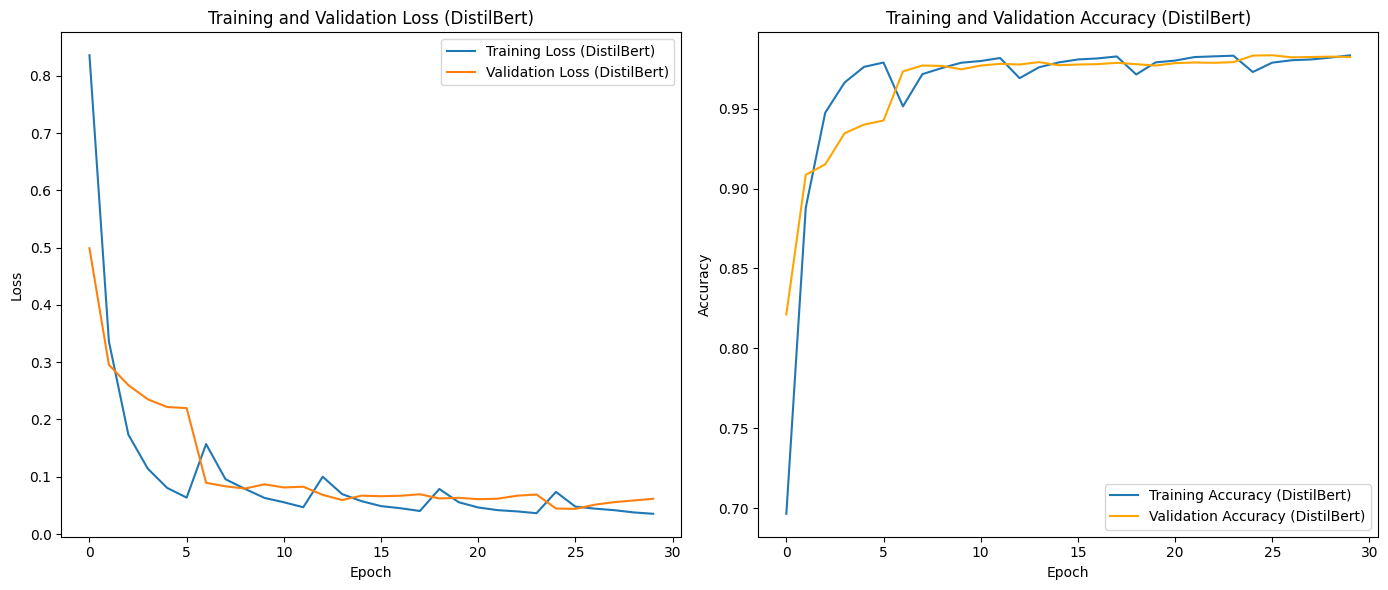

In [ ]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(14, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses_distilbert, label='Training Loss (DistilBert)')
plt.plot(val_losses_distilbert, label='Validation Loss (DistilBert)')
plt.title('Training and Validation Loss (DistilBert)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_distilbert, label='Training Accuracy (DistilBert)')
plt.plot(val_accuracies_distilbert, label='Validation Accuracy (DistilBert)', color='orange')
plt.title('Training and Validation Accuracy (DistilBert)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


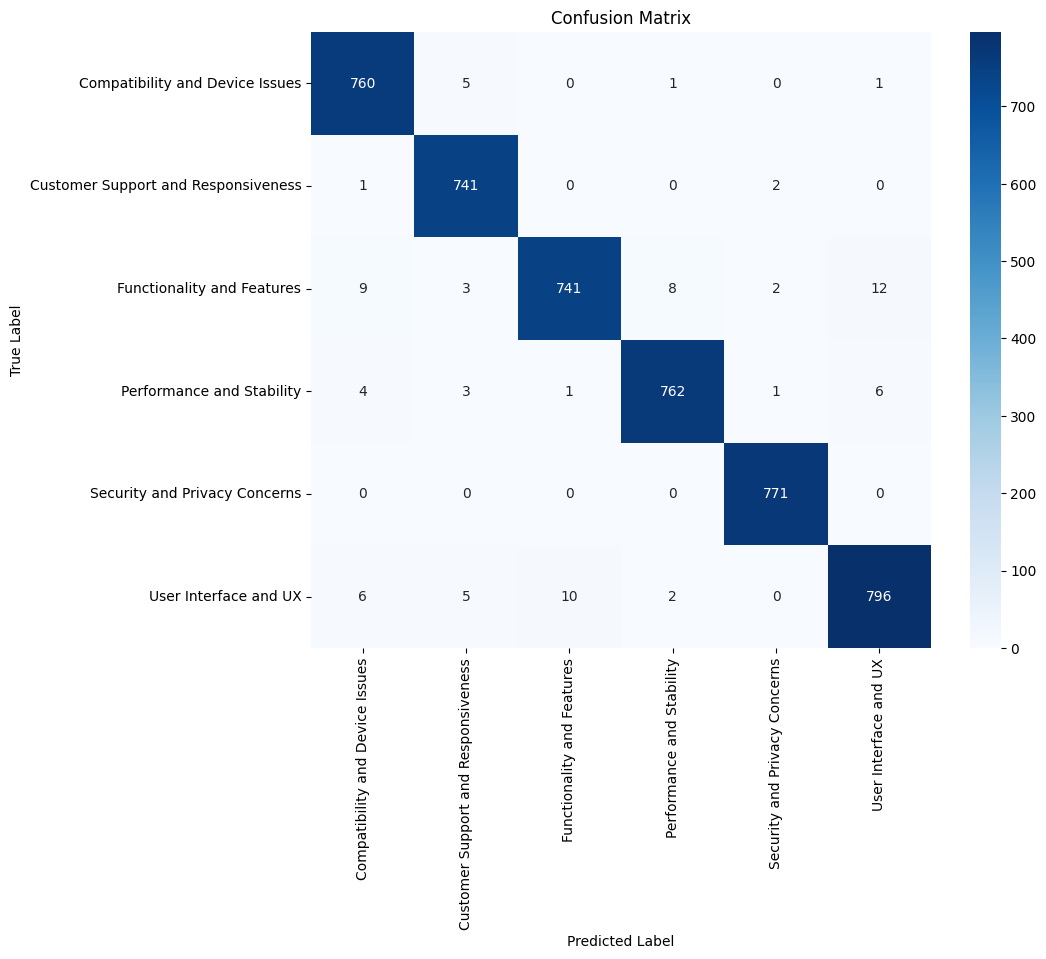

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(true_labels, predictions, class_labels):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage after validation
plot_confusion_matrix(true_labels_distilbert, preds_distilbert, class_labels)


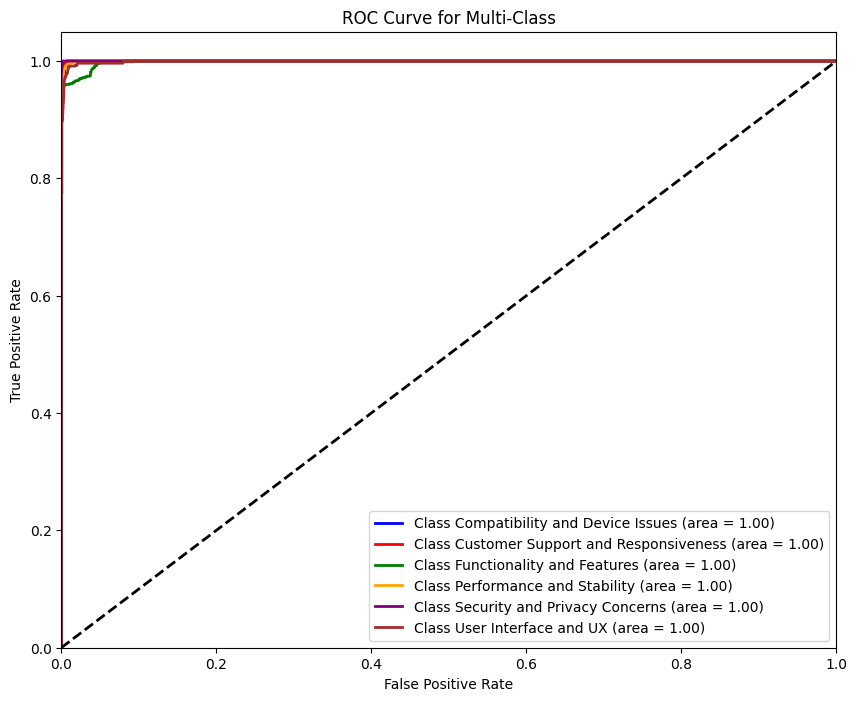

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# Convert list to numpy arrays
pred_probs_distilbert = np.array(pred_probs_distilbert)
true_labels_distilbert = np.array(true_labels_distilbert)

# Binarize labels for ROC curve
n_classes = len(class_labels)
y_true_bin = label_binarize(true_labels_distilbert, classes=list(range(n_classes)))

# Generate ROC curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs_distilbert[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()



In [ ]:
from sklearn.metrics import classification_report
# Calculate metrics for DistilBERT
report_distilbert = classification_report(true_labels_distilbert, preds_distilbert, target_names=class_labels)
print("DistilBERT Classification Report:")
print(report_distilbert)

DistilBERT Classification Report:
                                     precision    recall  f1-score   support

    Compatibility and Device Issues       0.97      0.99      0.98       767
Customer Support and Responsiveness       0.98      1.00      0.99       744
         Functionality and Features       0.99      0.96      0.97       775
          Performance and Stability       0.99      0.98      0.98       777
      Security and Privacy Concerns       0.99      1.00      1.00       771
              User Interface and UX       0.98      0.97      0.97       819

                           accuracy                           0.98      4653
                          macro avg       0.98      0.98      0.98      4653
                       weighted avg       0.98      0.98      0.98      4653



In [ ]:
# Initialize the BERT tokenizer
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# Tokenize data for BERT
def tokenize_data_bert(data):
    return bert_tokenizer(data['Base_Reviews'].tolist(), padding='max_length', truncation=True, max_length=128, return_tensors='pt', return_attention_mask=True)

tokenized_data_bert = tokenize_data_bert(df)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class TextDatasetBERT(Dataset):
    def __init__(self, inputs, labels, attention_masks):
        self.inputs = inputs
        self.labels = labels
        self.attention_masks = attention_masks

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx].clone().detach().to(torch.long),
            'attention_mask': self.attention_masks[idx].clone().detach().to(torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
# Initialize BERT model
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['category'].unique()))
optimizer_bert = AdamW(model_bert.parameters(), lr=2e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

# Train model for BERT
def train_model_bert(train_loader, val_loader, epochs):
    # Initialize the learning rate scheduler
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer_bert, num_warmup_steps=0, num_training_steps=total_steps)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model_bert.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            optimizer_bert.zero_grad()
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_bert(inputs, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer_bert.step()
            scheduler.step()  # Update learning rate

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        avg_train_accuracy = correct_predictions / total_samples
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)

        # Validation
        model_bert.eval()
        val_loss = 0
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_ids'].to(device)
                attention_masks = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model_bert(inputs, attention_mask=attention_masks, labels=labels)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct_predictions += torch.sum(preds == labels).item()
                total_samples += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = correct_predictions / total_samples
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')

    return model_bert, history

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# K-Fold Cross Validation for BERT
kf = KFold(n_splits=5)
accuracies_bert = []
train_losses_bert = []
val_losses_bert = []
train_accuracies_bert = []
val_accuracies_bert = []

for train_idx, val_idx in kf.split(tokenized_data_bert['input_ids']):
    # Split tokenized data
    train_inputs_bert = tokenized_data_bert['input_ids'][train_idx]
    val_inputs_bert = tokenized_data_bert['input_ids'][val_idx]
    train_attention_masks_bert = tokenized_data_bert['attention_mask'][train_idx]
    val_attention_masks_bert = tokenized_data_bert['attention_mask'][val_idx]

    # Labels
    train_labels_bert = df['category'].iloc[train_idx].values
    val_labels_bert = df['category'].iloc[val_idx].values

    # Create datasets
    train_dataset_bert = TextDatasetBERT(train_inputs_bert, train_labels_bert, train_attention_masks_bert)
    val_dataset_bert = TextDatasetBERT(val_inputs_bert, val_labels_bert, val_attention_masks_bert)

    # Create dataloaders
    train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
    val_loader_bert = DataLoader(val_dataset_bert, batch_size=16)

    # Train model
    model_bert, history_bert = train_model_bert(train_loader_bert, val_loader_bert, epochs=6)

    # Collect history
    train_losses_bert.extend(history_bert['train_loss'])
    val_losses_bert.extend(history_bert['val_loss'])
    train_accuracies_bert.extend(history_bert['train_accuracy'])
    val_accuracies_bert.extend(history_bert['val_accuracy'])

Epoch 1, Train Loss: 0.8708, Train Accuracy: 0.6758, Val Loss: 0.4594, Val Accuracy: 0.8376
Epoch 2, Train Loss: 0.3119, Train Accuracy: 0.8971, Val Loss: 0.2604, Val Accuracy: 0.9147
Epoch 3, Train Loss: 0.1500, Train Accuracy: 0.9550, Val Loss: 0.2351, Val Accuracy: 0.9334
Epoch 4, Train Loss: 0.0955, Train Accuracy: 0.9722, Val Loss: 0.2321, Val Accuracy: 0.9394
Epoch 5, Train Loss: 0.0701, Train Accuracy: 0.9783, Val Loss: 0.2471, Val Accuracy: 0.9364
Epoch 6, Train Loss: 0.0560, Train Accuracy: 0.9807, Val Loss: 0.2303, Val Accuracy: 0.9426
Epoch 1, Train Loss: 0.1649, Train Accuracy: 0.9489, Val Loss: 0.0853, Val Accuracy: 0.9742
Epoch 2, Train Loss: 0.0940, Train Accuracy: 0.9717, Val Loss: 0.0814, Val Accuracy: 0.9779
Epoch 3, Train Loss: 0.0712, Train Accuracy: 0.9761, Val Loss: 0.0754, Val Accuracy: 0.9787
Epoch 4, Train Loss: 0.0589, Train Accuracy: 0.9791, Val Loss: 0.0785, Val Accuracy: 0.9766
Epoch 5, Train Loss: 0.0510, Train Accuracy: 0.9804, Val Loss: 0.0807, Val Accur

In [ ]:
# Accuracy calculation
accuracy_bert = sum([pred == label for pred, label in zip(preds_bert, true_labels_bert)]) / len(true_labels_bert)
accuracies_bert.append(accuracy_bert)
model_bert.eval()
pred_probs_bert, true_labels_bert = [], []
with torch.no_grad():
    for batch in val_loader_bert:
        inputs = batch['input_ids'].to(device)
        attention_masks = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model_bert(inputs, attention_mask=attention_masks)

        # Collect class probabilities
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred_probs_bert.extend(probs.cpu().numpy())
        true_labels_bert.extend(labels.cpu().numpy())

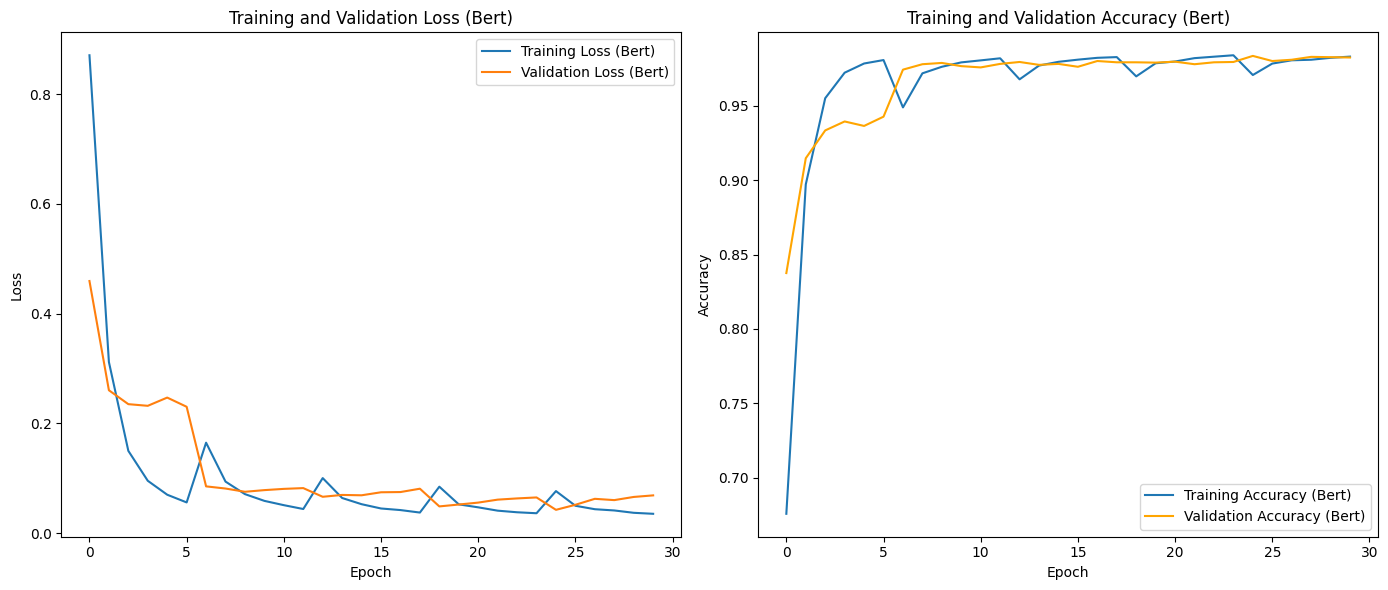

In [ ]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(14, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses_bert, label='Training Loss (Bert)')
plt.plot(val_losses_bert, label='Validation Loss (Bert)')
plt.title('Training and Validation Loss (Bert)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_bert, label='Training Accuracy (Bert)')
plt.plot(val_accuracies_bert, label='Validation Accuracy (Bert)', color='orange')
plt.title('Training and Validation Accuracy (Bert)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


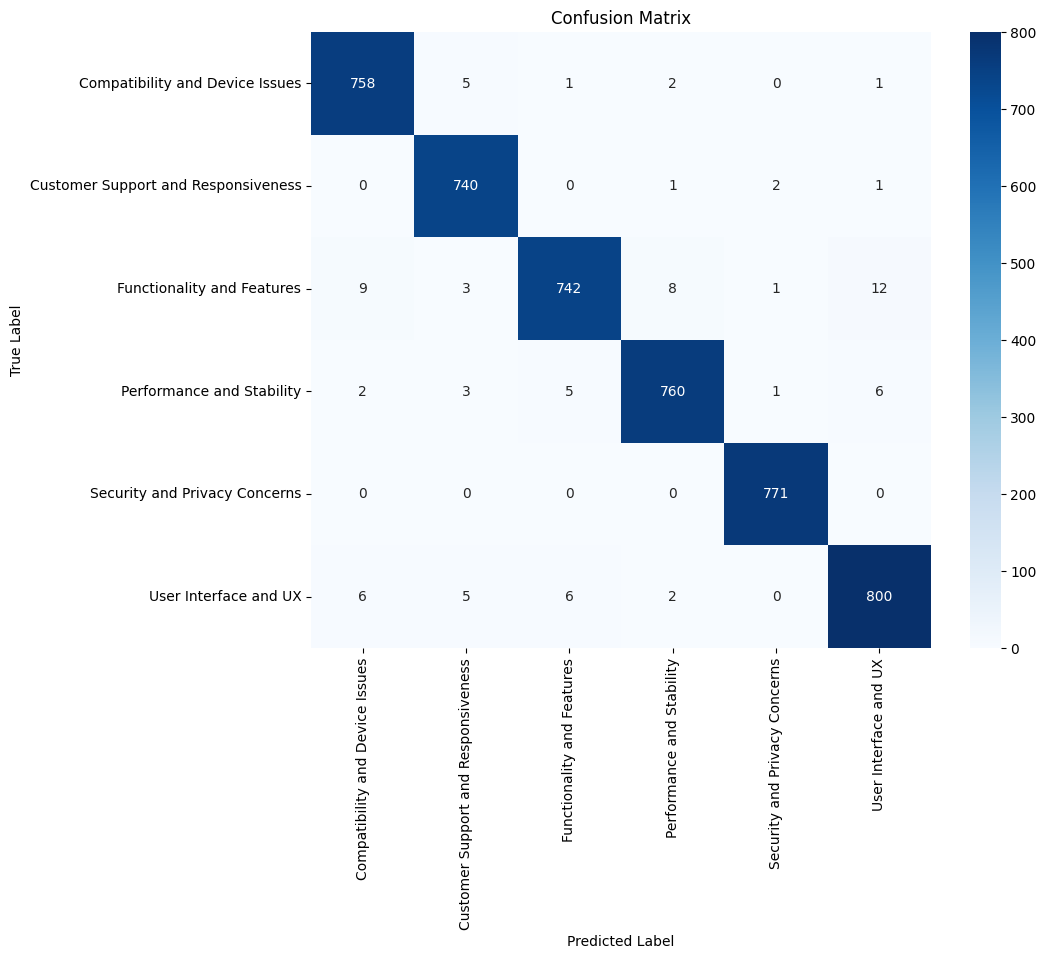

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(true_labels, predictions, class_labels):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage after validation
plot_confusion_matrix(true_labels_bert, preds_bert, class_labels)

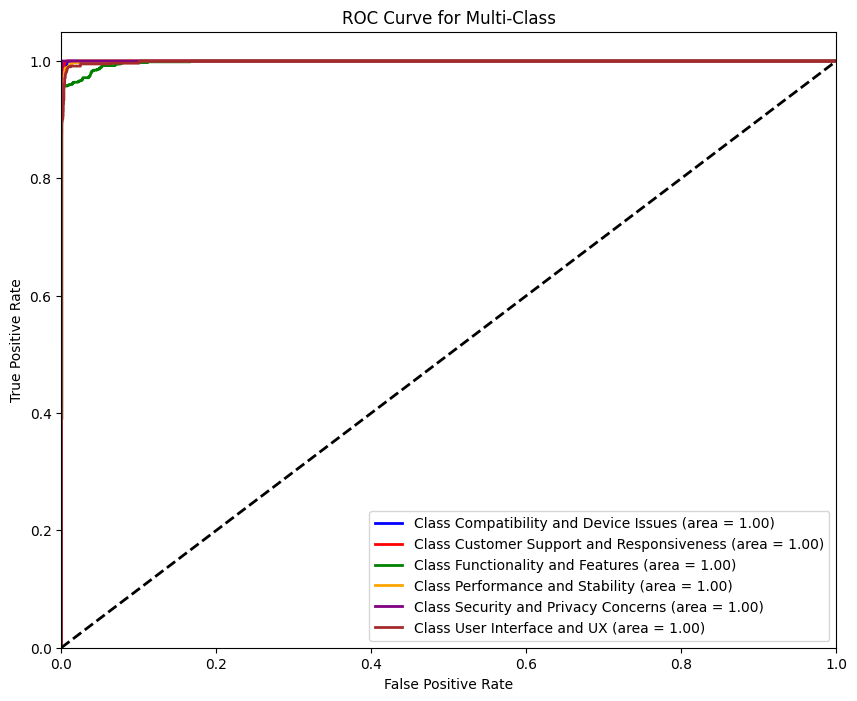

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# Convert list to numpy arrays
pred_probs_bert = np.array(pred_probs_bert)
true_labels_bert = np.array(true_labels_bert)

# Binarize labels for ROC curve
n_classes = len(class_labels)
y_true_bin = label_binarize(true_labels_bert, classes=list(range(n_classes)))

# Generate ROC curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs_bert[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
# Calculate metrics for BERT
report_bert = classification_report(true_labels_bert, preds_bert, target_names=class_labels)
print("BERT Classification Report:")
print(report_bert)

BERT Classification Report:
                                     precision    recall  f1-score   support

    Compatibility and Device Issues       0.98      0.99      0.98       767
Customer Support and Responsiveness       0.98      0.99      0.99       744
         Functionality and Features       0.98      0.96      0.97       775
          Performance and Stability       0.98      0.98      0.98       777
      Security and Privacy Concerns       0.99      1.00      1.00       771
              User Interface and UX       0.98      0.98      0.98       819

                           accuracy                           0.98      4653
                          macro avg       0.98      0.98      0.98      4653
                       weighted avg       0.98      0.98      0.98      4653



In [ ]:
# Initialize the RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
# Tokenize data for RoBERTa
def tokenize_data_roberta(data):
    return roberta_tokenizer(data['Base_Reviews'].tolist(), padding='max_length', truncation=True, max_length=128, return_tensors='pt', return_attention_mask=True)

tokenized_data_roberta = tokenize_data_roberta(df)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class TextDatasetRoBERTa(Dataset):
    def __init__(self, inputs, labels, attention_masks):
        self.inputs = inputs
        self.labels = labels
        self.attention_masks = attention_masks

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx].clone().detach().to(torch.long),
            'attention_mask': self.attention_masks[idx].clone().detach().to(torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
# Initialize RoBERTa model
model_roberta = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(df['category'].unique()))
optimizer_roberta = AdamW(model_roberta.parameters(), lr=2e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

# Train model for RoBERTa
def train_model_roberta(train_loader, val_loader, epochs):
    # Initialize the learning rate scheduler
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer_roberta, num_warmup_steps=0, num_training_steps=total_steps)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model_roberta.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            optimizer_roberta.zero_grad()
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_roberta(inputs, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer_roberta.step()
            scheduler.step()  # Update learning rate

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        avg_train_accuracy = correct_predictions / total_samples
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)

        # Validation
        model_roberta.eval()
        val_loss = 0
        correct_predictions = 0
        total_samples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input_ids'].to(device)
                attention_masks = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model_roberta(inputs, attention_mask=attention_masks, labels=labels)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1)
                correct_predictions += torch.sum(preds == labels).item()
                total_samples += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = correct_predictions / total_samples
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}')

    return model_roberta, history

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# K-Fold Cross Validation for RoBERTa
kf = KFold(n_splits=5)
accuracies_roberta = []
train_losses_roberta = []
val_losses_roberta = []
train_accuracies_roberta = []
val_accuracies_roberta = []

for train_idx, val_idx in kf.split(tokenized_data_roberta['input_ids']):
    # Split tokenized data
    train_inputs_roberta = tokenized_data_roberta['input_ids'][train_idx]
    val_inputs_roberta = tokenized_data_roberta['input_ids'][val_idx]
    train_attention_masks_roberta = tokenized_data_roberta['attention_mask'][train_idx]
    val_attention_masks_roberta = tokenized_data_roberta['attention_mask'][val_idx]

    # Labels
    train_labels_roberta = df['category'].iloc[train_idx].values
    val_labels_roberta = df['category'].iloc[val_idx].values

    # Create datasets
    train_dataset_roberta = TextDatasetRoBERTa(train_inputs_roberta, train_labels_roberta, train_attention_masks_roberta)
    val_dataset_roberta = TextDatasetRoBERTa(val_inputs_roberta, val_labels_roberta, val_attention_masks_roberta)

    # Create dataloaders
    train_loader_roberta = DataLoader(train_dataset_roberta, batch_size=16, shuffle=True)
    val_loader_roberta = DataLoader(val_dataset_roberta, batch_size=16)

    # Train model
    model_roberta, history_roberta = train_model_roberta(train_loader_roberta, val_loader_roberta, epochs=6)

    # Collect history
    train_losses_roberta.extend(history_roberta['train_loss'])
    val_losses_roberta.extend(history_roberta['val_loss'])
    train_accuracies_roberta.extend(history_roberta['train_accuracy'])
    val_accuracies_roberta.extend(history_roberta['val_accuracy'])

Epoch 1, Train Loss: 0.8699, Train Accuracy: 0.6823, Val Loss: 0.5571, Val Accuracy: 0.8043
Epoch 2, Train Loss: 0.4262, Train Accuracy: 0.8534, Val Loss: 0.3334, Val Accuracy: 0.8896
Epoch 3, Train Loss: 0.2411, Train Accuracy: 0.9186, Val Loss: 0.3404, Val Accuracy: 0.8919
Epoch 4, Train Loss: 0.1532, Train Accuracy: 0.9520, Val Loss: 0.2937, Val Accuracy: 0.9151
Epoch 5, Train Loss: 0.1062, Train Accuracy: 0.9678, Val Loss: 0.2505, Val Accuracy: 0.9334
Epoch 6, Train Loss: 0.0801, Train Accuracy: 0.9750, Val Loss: 0.2433, Val Accuracy: 0.9366
Epoch 1, Train Loss: 0.2170, Train Accuracy: 0.9316, Val Loss: 0.1131, Val Accuracy: 0.9645
Epoch 2, Train Loss: 0.1311, Train Accuracy: 0.9598, Val Loss: 0.1111, Val Accuracy: 0.9706
Epoch 3, Train Loss: 0.0987, Train Accuracy: 0.9704, Val Loss: 0.0933, Val Accuracy: 0.9761
Epoch 4, Train Loss: 0.0801, Train Accuracy: 0.9751, Val Loss: 0.0913, Val Accuracy: 0.9761
Epoch 5, Train Loss: 0.0655, Train Accuracy: 0.9783, Val Loss: 0.0877, Val Accur

In [ ]:
# Initialize lists to store predicted probabilities and true labels
pred_probs_roberta, true_labels_roberta = [], []

# Switch to evaluation mode
model_roberta.eval()

# Collect probabilities and true labels from the validation set
with torch.no_grad():
    for batch in val_loader_roberta:
        inputs = batch['input_ids'].to(device)
        attention_masks = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model_roberta(inputs, attention_mask=attention_masks)

        # Collect class probabilities
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred_probs_roberta.extend(probs.cpu().numpy())

        # Store true labels
        true_labels_roberta.extend(labels.cpu().numpy())

# Convert the probabilities to predictions (class with the highest probability)
preds_roberta = np.argmax(pred_probs_roberta, axis=1)

# Accuracy calculation
accuracy_roberta = sum([pred == label for pred, label in zip(preds_roberta, true_labels_roberta)]) / len(true_labels_roberta)
accuracies_roberta.append(accuracy_roberta)

print(f"Validation Accuracy for Roberta: {accuracy_roberta:.4f}")


Validation Accuracy for Roberta: 0.9813


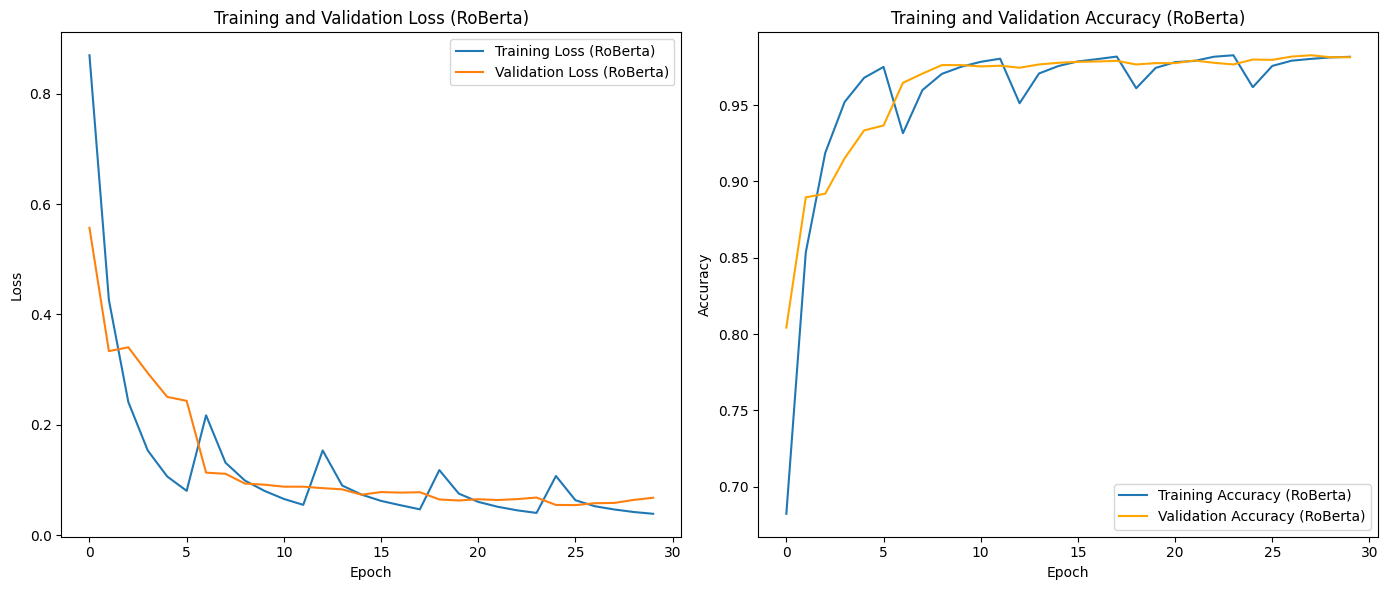

In [ ]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(14, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses_roberta, label='Training Loss (RoBerta)')
plt.plot(val_losses_roberta, label='Validation Loss (RoBerta)')
plt.title('Training and Validation Loss (RoBerta)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_roberta, label='Training Accuracy (RoBerta)')
plt.plot(val_accuracies_roberta, label='Validation Accuracy (RoBerta)', color='orange')
plt.title('Training and Validation Accuracy (RoBerta)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


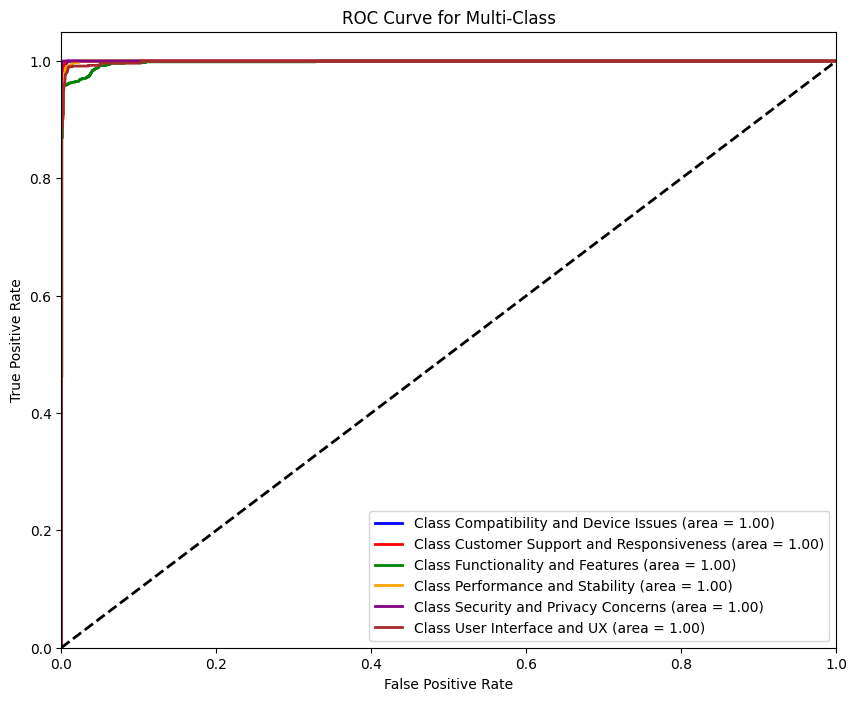

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# Convert list to numpy arrays
pred_probs_roberta = np.array(pred_probs_roberta)
true_labels_roberta = np.array(true_labels_roberta)

# Binarize labels for ROC curve
n_classes = len(class_labels)
y_true_bin = label_binarize(true_labels_roberta, classes=list(range(n_classes)))

# Generate ROC curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs_roberta[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class')
plt.legend(loc="lower right")
plt.show()


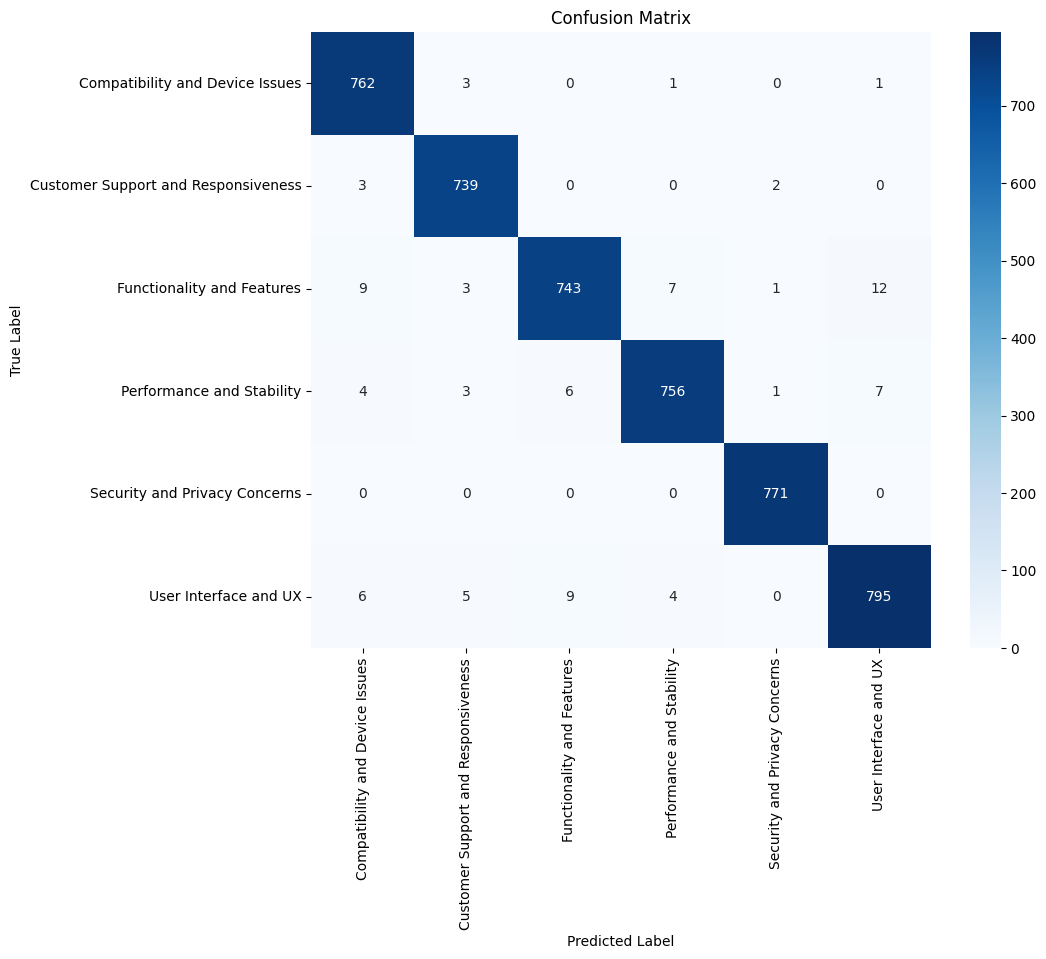

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(true_labels, predictions, class_labels):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage after validation
plot_confusion_matrix(true_labels_roberta, preds_roberta, class_labels)

In [ ]:
from sklearn.metrics import classification_report
# Calculate metrics for ROBERTA
report_roberta = classification_report(true_labels_roberta, preds_roberta, target_names=class_labels)
print("ROBERTA Classification Report:")
print(report_roberta)

ROBERTA Classification Report:
                                     precision    recall  f1-score   support

    Compatibility and Device Issues       0.97      0.99      0.98       767
Customer Support and Responsiveness       0.98      0.99      0.99       744
         Functionality and Features       0.98      0.96      0.97       775
          Performance and Stability       0.98      0.97      0.98       777
      Security and Privacy Concerns       0.99      1.00      1.00       771
              User Interface and UX       0.98      0.97      0.97       819

                           accuracy                           0.98      4653
                          macro avg       0.98      0.98      0.98      4653
                       weighted avg       0.98      0.98      0.98      4653



In [ ]:
# Print accuracies
print(f"BERT Accuracy: {accuracy_bert:.4f}")
print(f"DistilBERT Accuracy: {accuracy_distilbert:.4f}")
print(f"RoBERTa Accuracy: {accuracy_roberta:.4f}")

BERT Accuracy: 0.9824
DistilBERT Accuracy: 0.9824
RoBERTa Accuracy: 0.9813


<ipython-input-84-b3e075742958>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=data, palette='Set2')


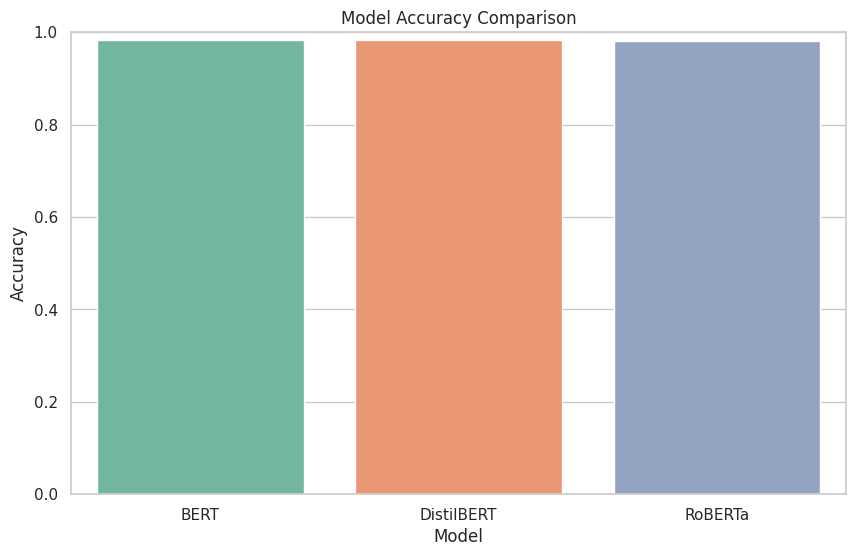

In [ ]:
# Plot accuracies
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")


# Data for plotting
model_names = ['BERT', 'DistilBERT', 'RoBERTa']
accuracies = [accuracy_bert, accuracy_distilbert, accuracy_roberta]

# Create a DataFrame
data = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies})

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=data, palette='Set2')

# Customize the plot
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # Accuracy range
plt.show()